In [8]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
from PIL import Image
import tensorflow.compat.v1 as tf
import pprint
%matplotlib inline

In [32]:
#pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
#pp.pprint(model)

In [34]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4 * n_H * n_W * n_C) * (tf.reduce_sum(tf.compat.v1.square(tf.subtract(a_C, a_G, name='sub'), name='square'), name='sum'))
  
    return J_content

In [35]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))



J_content = 7.6410227


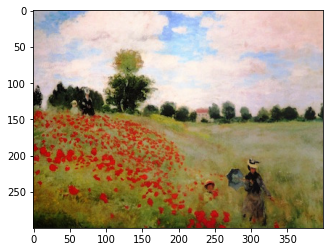

In [36]:
style_image = imageio.imread("images/monet.jpg")
imshow(style_image);

In [37]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, A, transpose_b = True, name=None)
    
    return GA

In [38]:
#tf.reset_default_graph()
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[ 15.615461  12.248833 -29.87157 ]
 [ 12.248833  10.877857 -19.879116]
 [-29.87157  -19.879116  67.08007 ]]


In [39]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S, shape=[n_H * n_W, n_C], name=None)
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, shape=[n_H * n_W, n_C], name=None)
    a_G = tf.transpose(a_G)

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = ((.5 / (n_H * n_W * n_C)) ** 2)*(  tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(GS, GG))))   )
    
    return J_style_layer



In [40]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 2.2849257


In [41]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [42]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [43]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    
    return J

In [44]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## Start the interactive part

In [45]:
tf.disable_eager_execution() 
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/home/dietmar/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [46]:
content_image = imageio.imread("images/profilbild-1.tif")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
content_image.shape

(300, 400, 3)


(1, 300, 400, 3)

In [47]:
style_image = imageio.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)
style_image.shape

(1, 300, 400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


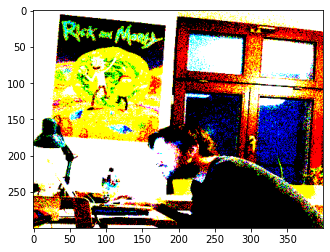

In [48]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [49]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [50]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [51]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [52]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha=10, beta=40)
### END CODE HERE ###

In [53]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [54]:
def model_nn(sess, input_image, num_iterations = 200):
    
    tf.disable_eager_execution() 
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [56]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3839323600.0
content cost = 13796.093
style cost = 95979640.0
Iteration 20 :
total cost = 549090100.0
content cost = 20063.928
style cost = 13722237.0
Iteration 40 :
total cost = 297011900.0
content cost = 21805.3
style cost = 7419846.5
Iteration 60 :
total cost = 206485870.0
content cost = 22619.21
style cost = 5156492.0
Iteration 80 :
total cost = 159225810.0
content cost = 23106.723
style cost = 3974868.2
Iteration 100 :
total cost = 129278740.0
content cost = 23552.582
style cost = 3226080.2
Iteration 120 :
total cost = 108380024.0
content cost = 23901.523
style cost = 2703525.2
Iteration 140 :
total cost = 93119140.0
content cost = 24178.117
style cost = 2321933.8
Iteration 160 :
total cost = 81428690.0
content cost = 24419.484
style cost = 2029612.5
Iteration 180 :
total cost = 72143416.0
content cost = 24654.777
style cost = 1797421.8


array([[[[ 83.331406 ,  -8.341711 ,  47.59096  ],
         [119.97351  ,  -0.6667805, 122.59337  ],
         [ 59.958122 , -13.625298 , 155.92311  ],
         ...,
         [-21.408392 , 106.59054  , 100.16983  ],
         [-35.32964  , 115.95376  , 108.67657  ],
         [-14.364762 , 145.0388   , 167.30182  ]],

        [[118.820366 ,  -4.4468503, 112.75059  ],
         [111.89833  ,  12.686041 , 118.55931  ],
         [ 92.222115 , -22.27356  , 158.16368  ],
         ...,
         [-25.35006  , 107.32705  , 106.704    ],
         [-17.552649 , 100.96574  ,  89.7803   ],
         [ -8.419004 , 127.879234 , 114.770065 ]],

        [[136.89908  ,  12.398578 ,  40.70142  ],
         [133.32005  ,  14.560844 ,  85.834564 ],
         [ 98.27579  ,  21.025051 , 125.07568  ],
         ...,
         [ 19.224209 ,  71.41232  , 101.244835 ],
         [ 14.409683 ,  80.9981   , 104.32171  ],
         [  3.898807 ,  81.09893  , 109.302185 ]],

        ...,

        [[ -3.2749443, -20.403528 , -3